In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import regularizers

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from utils import windowed_dataset, build_basic_lstm,split_train_test,split_train_test_val
from config import *

import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

mpl.rcParams['figure.figsize'] = [35.0, 7.0]
HDFStore=pd.HDFStore
h5filename=h5filename
print(h5filename)

/data/elekin/data/results/handwriting/archimedean-17.h5


In [2]:
hdf = HDFStore(h5filename)
hdf.keys()

['/source/dataset',
 '/source/labels',
 '/results/residues/features',
 '/results/residues/rd',
 '/results/radius/features',
 '/results/radius/r']

In [3]:
x=hdf['/results/residues/rd'].T.values.astype('float32')
y=hdf['/source/labels'].values.astype('int8').reshape(-1,1)
hdf.close()
x.shape

(50, 4096)

Window function is applied to Dataset objects. Same windows lenghts for each time series corresponding to each subject are built asigning the rigth label. Then they are included in same Dataset object.

In [4]:
#windowing parameters
num_features = x.shape[1]
window_size = int(num_features/5 + 1)
shuffle_buffer = num_features
batch_size = 1

In [5]:
features=tf.data.Dataset.from_tensor_slices(x)
labels=(y)

In [6]:
#series, window_size, batch_size,label
for i,features in enumerate(x):
    new = windowed_dataset(features,window_size,batch_size,labels[i])
    if i>0:
        dataset = tf.data.Dataset.concatenate(dataset,new)
    else:
        dataset = new
        
dataset.cache()
dataset.element_spec

(TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 TensorSpec(shape=(1,), dtype=tf.int8, name=None))

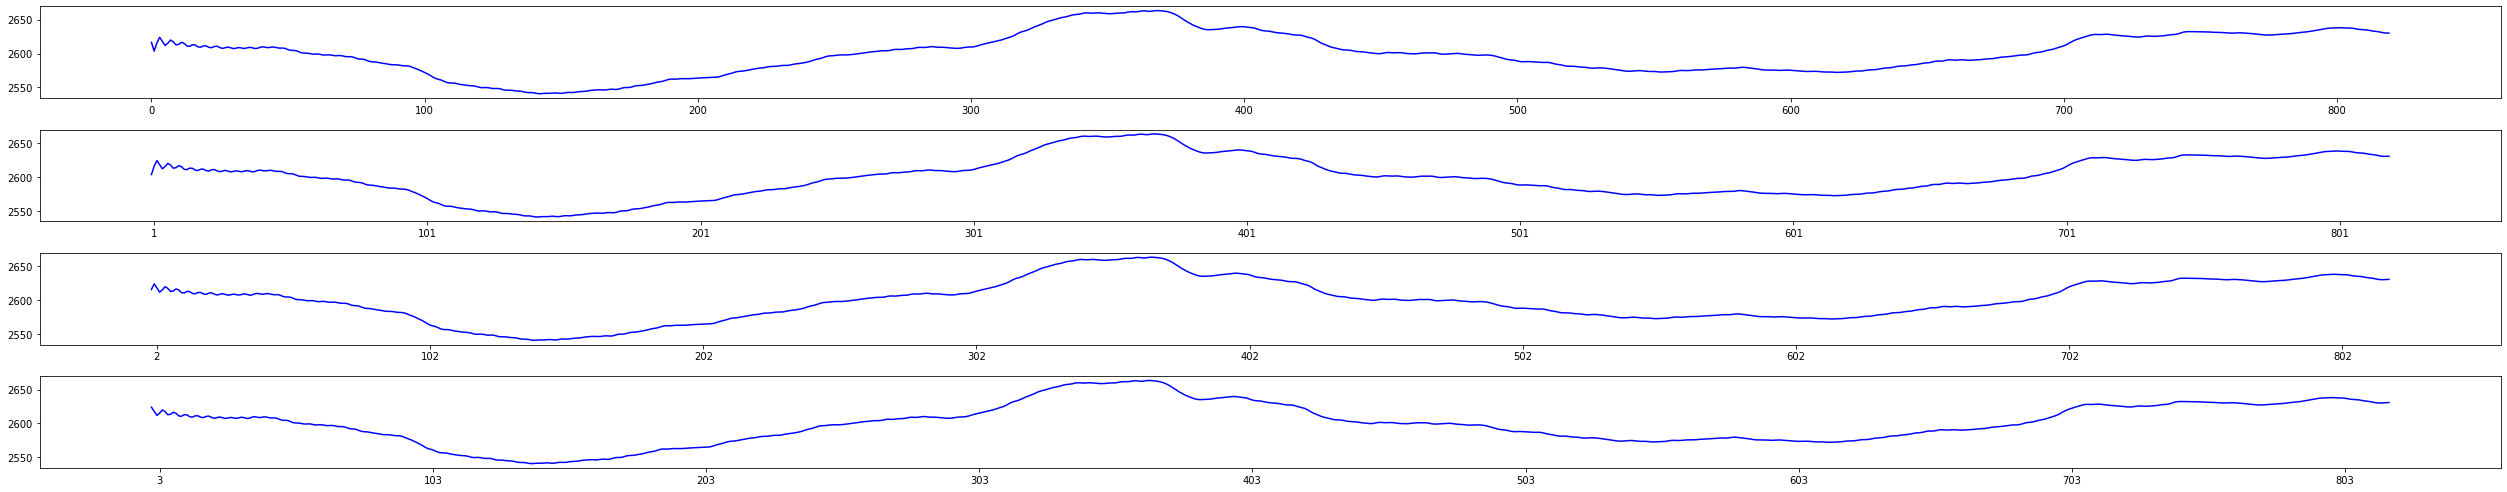

In [8]:
fig, axes = plt.subplots(4,1)
fig.tight_layout()
i=0
for (feat,label),ax in zip(dataset.take(4),axes):
    ax.plot(feat.numpy(), color=colors[label.numpy()[0]])
    ax.set_xticks(range(i,window_size,100))
    i+=1

We can apply filters to a Dataset object

In [9]:
positive_filter=lambda x,y: tf.equal(y, 1)[0]
negative_filter=lambda x,y: tf.equal(y, 0)[0]
positive_samples=dataset.filter(positive_filter).cache()
negative_samples=dataset.filter(negative_filter).cache()

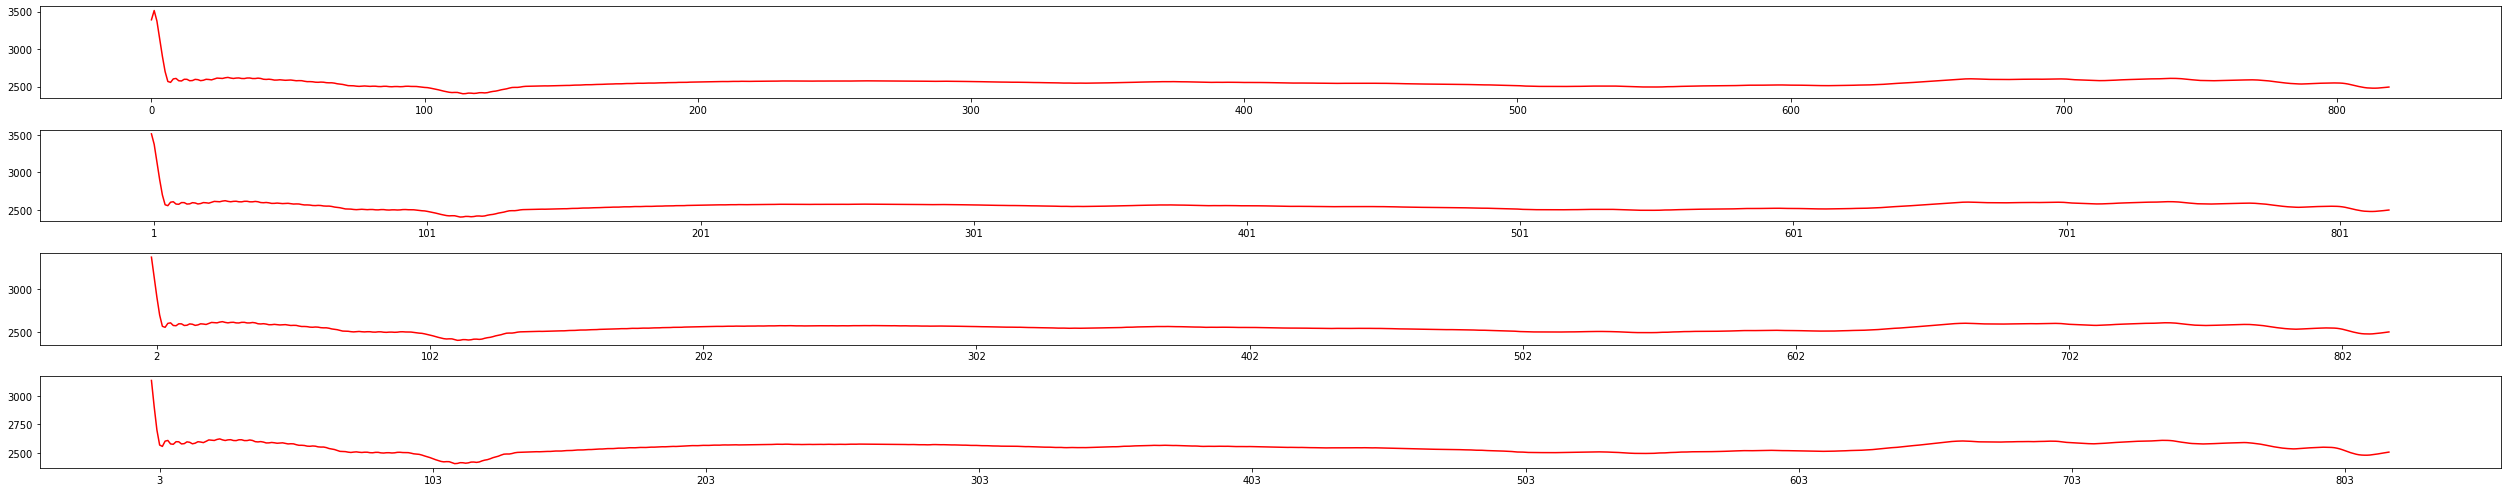

In [11]:
fig, axes = plt.subplots(4,1)
fig.tight_layout()
i=0
for (feat,label),ax in zip(positive_samples.take(4), axes):
    ax.plot(feat.numpy(), color=colors[label.numpy()[0]])
    ax.set_xticks(range(i,window_size,100))
    i+=1

It is possible to access just to one element using python iterator. In the example bellow it is showed also how to shuffle the dataset and batch together some examples into minibatches:

In [12]:
# iterator = iter(positive_samples.shuffle(shuffle_buffer).cache().batch(batch_size).cache())
# n_iterator = iter(negative_samples.shuffle(shuffle_buffer).cache().batch(batch_size).cache())
iterator = iter(positive_samples.batch(batch_size).cache())
n_iterator = iter(negative_samples.batch(batch_size).cache())

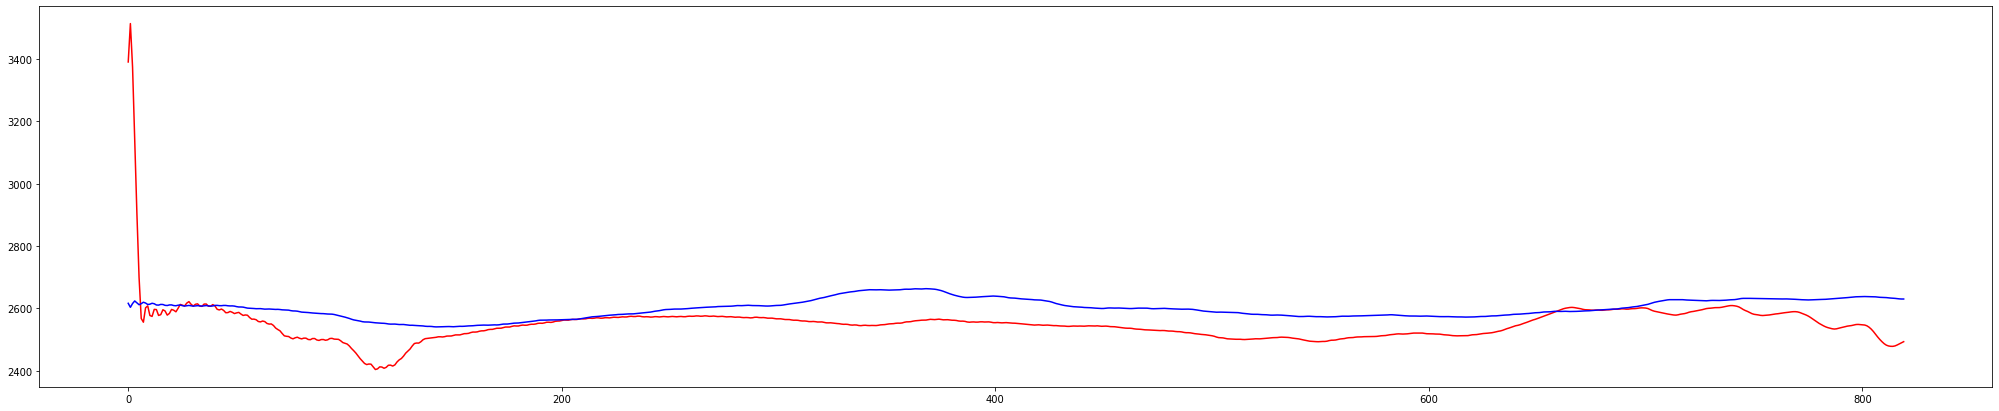

In [13]:
first = iterator.next()
n_first = n_iterator.next()

plt.plot(first[0].numpy()[0], color=colors[first[1].numpy()[0][0]])
plt.plot(n_first[0].numpy()[0], color=colors[n_first[1].numpy()[0][0]])

Now we are able to build different dataset splits for training pruposes

In [105]:
# DATASET_SIZE = int((num_features/window_size)*50)
# #TODO import from utils API
# train_size = int(0.7 * DATASET_SIZE)
# val_size = int(0.15 * DATASET_SIZE)
# test_size = int(0.15 * DATASET_SIZE)

# full_dataset = dataset
# full_dataset = full_dataset.shuffle(DATASET_SIZE, seed=seed)
# train_dataset = full_dataset.take(train_size).batch(mini_batch_size).prefetch(2).cache()
# test_dataset = full_dataset.skip(train_size)
# val_dataset = test_dataset.skip(test_size).batch(mini_batch_size).prefetch(2).cache()
# test_dataset = test_dataset.take(test_size).batch(mini_batch_size).prefetch(2).cache()

In [10]:
DATASET_SIZE = int((num_features/window_size)*50)
train_dataset, val_dataset, test_dataset = split_train_test_val(dataset, DATASET_SIZE, train_ratio=0.67, val_ratio=0.17, test_ratio=0.16, shuffle_buffer=DATASET_SIZE, seed=seed, mini_batch_size=mini_batch_size)

In [16]:
# #Early stop configuration
earlystop_callback = EarlyStopping(
  monitor='val_accuracy', min_delta=1e-3,
  patience=200)

training_earlystop_callback = EarlyStopping(
  monitor='accuracy', min_delta=1e-4,
  patience=200)

def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        earlystop_callback,
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, min_delta=1e-5),
        #tf.keras.callbacks.TensorBoard(logdir/name),
      ]

def compile_and_fit(model, train_dataset, test_dataset, name, optimizer=None, max_epochs=1000):
    tf.keras.backend.clear_session()# avoid clutter from old models and layers, especially when memory is limited
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])
    model.summary()
    tf.random.set_seed(seed) # establecemos la semilla para tensorflow
    history = model.fit(train_dataset, 
                        use_multiprocessing=True, 
                        validation_data=test_dataset, epochs=max_epochs, 
                        callbacks=get_callbacks(name),
                        verbose=1, shuffle=True)
    return history

# Many models train better if you gradually reduce the learning rate during training. 
# Use optimizers.schedules to reduce the learning rate over time:
def get_optimizer(steps_per_epoch=1, lr=1e-4, multiplier=1000):
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(lr,
                                                                 decay_steps=steps_per_epoch*multiplier,
                                                                 decay_rate=1,
                                                                 staircase=False)
    return tf.keras.optimizers.Adam(lr_schedule)

In [17]:
size_histories = {}
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [18]:
# LSTM basic architectures --> #TODO import from utils API
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1),input_shape=(window_size,)))
model.add(tf.keras.layers.LSTM(8, activation=tf.nn.tanh, return_sequences=False))
# model.add(tf.keras.layers.Dropout(dropout))
model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))

size_histories['lstm/windows'] = compile_and_fit(model, train_dataset, 
                                              val_dataset,
                                              "fcnn/tiny", 
#                                               optimizer=get_optimizer(),
                                              optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
#                                               optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                              max_epochs=num_epochs)

print("\n#######################Evaluation###########################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['lstm/windows'].history["accuracy"]))
print('test acc:', max(size_histories['lstm/windows'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1, 820)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 26528     
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 26,537
Trainable params: 26,537
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10000
42/42 [==============================] - 29s 690ms/step - loss: 0.4731 - accuracy: 0.0000e+00 - val_loss: 0.2945 - val_accuracy: 0.4610

Epoch: 0, accuracy:0.0000,  loss:0.4731,  val_accuracy:0.4610,  val_loss:0.2945,  
.Epoch 2/10000
42/42 [==============================] - 27s 670ms/step - loss: 0.4480 - accuracy: 0.0000e+00 - val_loss: 0.2869 - val_accuracy: 0.46

KeyboardInterrupt: 

In [ ]:
plotter_loss = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=1)
plotter_loss.plot(size_histories)
# plt.ylim(0., 1.)

In [ ]:
plotter_acc = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=1)
plotter_acc.plot(size_histories)
# plt.ylim([0., 1.1])

In [57]:
fig, axes = plt.subplots(4,1)
fig.tight_layout()

f=lambda x,y: tf.equal(y, 1)[0]
i=0
for (x,y),ax in zip(dataset.filter(f).take(4), axes):
    ax.plot(x.numpy(), color=colors[y.numpy()[0]])
    ax.set_xticks(range(i,window_size,100))
    print(x.shape)
    input_tensor=tf.expand_dims(x, axis=1)
    print(model.predict(input_tensor))
    i+=1

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f4d7a74fa60> (for post_execute):


KeyboardInterrupt: 

In [63]:
iter(dataset.filter(f).take(4).cache()).next()
prediction=model.predict(first[0])
prediction

array([[0.01291427]], dtype=float32)

In [65]:
model.evaluate(test_dataset)[1]

10/10 [==============================] - 0s 768us/step - loss: 0.0130 - accuracy: 1.0000


1.0